# Model

Note: the `ml.g4dn.xlarge` is required to run this notebook in AWS due to it 1) being within class-enabled instances and 2) having CUDA availability.

In [2]:
!aws s3 ls


2023-08-29 23:43:16 sagemaker-studio-692960231031-wo7kgoszj2g
2023-08-29 23:50:01 sagemaker-us-east-1-692960231031
2023-08-30 00:34:21 vad49
2023-09-16 16:02:10 vad49-labdata


In [34]:
#!aws s3 ls s3://project17-bucket-alex/stories-and-books-nlp/mapping/char2idx.pkl



download: s3://project17-bucket-alex/stories-and-books-nlp/mapping/char2idx.pkl to ../../data/nlp-data/char2idx.pkl


In [4]:
if True is True: # set to true only for the first un
    # Setup - Run only once per Kernel App
    %conda install openjdk -y

    # install PySpark
    %pip install pyspark==3.2.0 s3fs pyarrow torch==1.13.0

    # restart kernel
    from IPython.core.display import HTML
    HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [2]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as F
from pyspark.sql.functions import col, length, isnan, when, count, regexp_extract, weekofyear, hour, avg, to_date, unix_timestamp, lit, corr


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import string
from tqdm import tqdm
import boto3
import pickle
from io import BytesIO
from pyspark.sql.functions import col, explode


pd.set_option('display.max_colwidth', 150) 
#pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)


In [3]:
# Import pyspark and build Spark session

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    #.config("spark-jars-packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-6e916b36-3f09-4362-9dbf-e6f74a8c4175;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 277ms :: artifacts dl 15ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

3.2.0


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [40]:
# read in the data
all_model_text = spark.read.parquet("s3a://project17-bucket-alex/stories-and-books-nlp/processed-data/")

#display(f"shape: ({all_model_text.count()}, {len(all_model_text.columns)})")
all_model_text.show()


+--------------------+--------------------+--------------------+
|                text|       custom_tokens|         text_as_int|
+--------------------+--------------------+--------------------+
|First of all, I n...|[first,  , of,  ,...|[22, 25, 34, 35, ...|
|I started a job a...|[i,  , started,  ...|[25, 1, 35, 36, 1...|
|My older brother ...|[my,  , older,  ,...|[29, 41, 1, 31, 2...|
|When I was a kid,...|[when,  , i,  , w...|[39, 24, 21, 30, ...|
|TL/DR on bottom!\...|[tldr,  , on,  , ...|[36, 28, 20, 34, ...|
|I have many stori...|[i,  , have,  , m...|[25, 1, 24, 17, 3...|
| \n\nFaults in Ma...|[ , faults,  , in...|[1, 22, 17, 37, 2...|
|My (24F) boyfrien...|[my,  , 24f,  , b...|[29, 41, 1, 7, 9,...|
|So, this wasn't r...|[so, ,,  , this, ...|[35, 31, 3, 1, 36...|
|\nEDIT: Hi! Still...|[edit,  , hi, !, ...|[21, 20, 25, 36, ...|
|tl;dr: So basical...|[tl, ;, dr,  , so...|[36, 28, 15, 20, ...|
|Obligatory, I mis...|[obligatory, ,,  ...|[31, 18, 28, 25, ...|
|Warning: mentions...|[wa

In [41]:
# all data
flattened_seq = all_model_text.select("text_as_int").rdd.flatMap(lambda x: x[0]).collect()

# calculate the size of the list object itself
total_size = sys.getsizeof(flattened_seq)

# add the size of each element in the list
for item in flattened_seq:
    total_size += sys.getsizeof(item)

# convert to megabytes
size_in_mb = total_size / (1024 ** 2)

print(f"size in MB: {size_in_mb}")


size in MB: 1036.9993515014648


In [42]:
# work on a subset of the data

data_use_pct = 0.15
all_model_text = all_model_text.sample(False, data_use_pct)



In [43]:
# helper functions
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [44]:

# collect all sequences into one long sequence
flattened_seq = all_model_text.select("text_as_int").rdd.flatMap(lambda x: x[0]).collect()

# convert the flattened sequence into a tensor
char_dataset = torch.tensor(flattened_seq, dtype=torch.long)



In [45]:
# calculate the size of the list object itself
total_size = sys.getsizeof(flattened_seq)

# add the size of each element in the list
for item in flattened_seq:
    total_size += sys.getsizeof(item)

# convert to megabytes
size_in_mb = total_size / (1024 ** 2)

print(f"size in MB: {size_in_mb}")



size in MB: 160.5936050415039


In [46]:
#local path
mapping_path = '../../data/nlp-data/char2idx.pkl'

# open
with open(mapping_path, 'rb') as file:
    char2idx = pickle.load(file)

# define
idx2char = {idx: char for char, idx in char2idx.items()}




In [47]:
# unique tokens
all_tokens = all_model_text.select(explode(col("custom_tokens"))).distinct().rdd.flatMap(lambda x: x).collect()

# vocab from tokens
vocab = sorted(set(all_tokens))


In [48]:
# define sequences
seq_length = 250
examples_per_epoch = len(char_dataset) // (seq_length + 1)


# create the dataset
#char_dataset = torch.tensor(text_as_int, dtype=torch.long)

sequences = []
targets = []
for i in range(0, len(char_dataset) - seq_length, seq_length):
    sequences.append(char_dataset[i:i+seq_length])
    targets.append(char_dataset[i+1:i+seq_length+1])

dataset = TensorDataset(torch.stack(sequences), torch.stack(targets))



# split it
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])


# turn into dataloader
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)



In [49]:

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        
        # output
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x)
        
        return x


In [50]:

# hyperparameters
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
n_layers = 2


# instantiate
model = RNN(vocab_size, embedding_dim, hidden_dim, n_layers).to(device)


display(model)


total_params = count_parameters(model)
print(f'total number of parameters: {total_params}')


RNN(
  (embedding): Embedding(30766, 128)
  (rnn): LSTM(128, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=30766, bias=True)
)

total number of parameters: 12766510


In [51]:
%%time

# training params
learning_rate = 0.01
num_epochs = 100

patience = 5  
best_val_loss = float('inf')
epochs_since_improvement = 0
tolerance = 0.01

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# save model in case of kernel crash
save_path = f"../../data/ml-data/"
model_name = f"rnn_model"
model_save_path = f'{save_path}{model_name}_{seq_length}_{data_use_pct}.pth'


# training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    
    model.train()
    running_train_loss = 0.0
    
    # progress bar
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    
    
    
    # loop through data loader
    for batch_idx, (data, target) in loop:
        
        # move to gpu
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        output = output.permute(0, 2, 1)
        
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()
        
        # acummulate loss
        running_train_loss += loss.item()
        
        # update tqdm bar
        loop.set_description(f"epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())
    
    # get avg loss for the epoch
    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)
    train_perplexity = torch.exp(torch.tensor(train_loss))
    
    
    # validate
    model.eval()
    running_val_loss = 0.0
    val_loop = tqdm(enumerate(val_loader), total=len(val_loader), leave=False)
    
    with torch.no_grad():
        
        # loop through validation
        for batch_idx, (data, target) in val_loop:
            
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            output = output.permute(0, 2, 1)
            
            loss = criterion(output, target)
            running_val_loss += loss.item()
            
            
            # tqdm
            val_loop.set_description(f"validation epoch [{epoch+1}/{num_epochs}]")
            val_loop.set_postfix(val_loss=loss.item())
    
    
    # get avg loss for the epoch
    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)
    val_perplexity = torch.exp(torch.tensor(val_loss))
    
    

    torch.save(model, model_save_path)
    
    
    # early stopping
    improvement = best_val_loss - val_loss
    if improvement >= tolerance:
        best_val_loss = val_loss
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    if epochs_since_improvement == patience:
        print(f"stopping early at epoch {epoch+1}")
        break

    
    # report
    print(f"epoch {epoch+1}/{num_epochs}, train loss: {train_loss:.4f}, train perplexity: {train_perplexity:.4f}, val loss: {val_loss:.4f}, val perplexity: {val_perplexity:.4f}")
    


# eval
model.eval()
test_loss = 0.0

with torch.no_grad():
    
    for batch_idx, (data, target) in enumerate(test_loader):
        
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        output = output.permute(0, 2, 1)
        loss = criterion(output, target)
        test_loss += loss.item()
        
        
test_loss /= len(test_loader)

# perplexity
test_perplexity = torch.exp(torch.tensor(test_loss))


# report
print(f"test loss: {test_loss:.4f}, test perplexity: {test_perplexity:.4f}")



epoch 1/100, train loss: 3.0076, train perplexity: 20.2379, val loss: 2.9298, val perplexity: 18.7247


epoch 2/100, train loss: 2.8308, train perplexity: 16.9597, val loss: 2.7601, val perplexity: 15.8009


epoch 3/100, train loss: 2.6667, train perplexity: 14.3921, val loss: 2.5363, val perplexity: 12.6333


epoch 4/100, train loss: 2.4603, train perplexity: 11.7086, val loss: 2.4315, val perplexity: 11.3758


epoch 5/100, train loss: 2.3807, train perplexity: 10.8125, val loss: 2.3838, val perplexity: 10.8463


epoch 6/100, train loss: 2.3459, train perplexity: 10.4422, val loss: 2.3346, val perplexity: 10.3257


epoch 7/100, train loss: 2.2755, train perplexity: 9.7326, val loss: 2.2845, val perplexity: 9.8203


epoch 8/100, train loss: 2.2126, train perplexity: 9.1399, val loss: 2.1912, val perplexity: 8.9457


epoch 9/100, train loss: 2.1788, train perplexity: 8.8355, val loss: 2.1826, val perplexity: 8.8694


epoch 10/100, train loss: 2.1580, train perplexity: 8.6541, val loss: 2.1617, val perplexity: 8.6858


epoch 11/100, train loss: 2.1351, train perplexity: 8.4578, val loss: 2.1645, val perplexity: 8.7099


epoch 12/100, train loss: 2.0840, train perplexity: 8.0367, val loss: 2.0823, val perplexity: 8.0231


epoch 13/100, train loss: 2.0523, train perplexity: 7.7856, val loss: 2.0422, val perplexity: 7.7077


epoch 14/100, train loss: 2.0253, train perplexity: 7.5782, val loss: 2.0232, val perplexity: 7.5627


epoch 15/100, train loss: 2.0051, train perplexity: 7.4272, val loss: 2.0040, val perplexity: 7.4183


epoch 16/100, train loss: 1.9835, train perplexity: 7.2684, val loss: 1.9825, val perplexity: 7.2609


epoch 17/100, train loss: 1.9545, train perplexity: 7.0601, val loss: 1.9390, val perplexity: 6.9521


epoch 18/100, train loss: 1.9254, train perplexity: 6.8577, val loss: 1.9547, val perplexity: 7.0619


epoch 19/100, train loss: 1.9020, train perplexity: 6.6992, val loss: 1.9430, val perplexity: 6.9800


epoch 20/100, train loss: 1.8813, train perplexity: 6.5623, val loss: 1.9810, val perplexity: 7.2503


epoch 21/100, train loss: 1.8555, train perplexity: 6.3951, val loss: 1.8720, val perplexity: 6.5016


epoch 22/100, train loss: 1.8359, train perplexity: 6.2705, val loss: 1.8478, val perplexity: 6.3458


epoch 23/100, train loss: 1.8280, train perplexity: 6.2217, val loss: 1.9469, val perplexity: 7.0072


epoch 24/100, train loss: 1.8125, train perplexity: 6.1257, val loss: 1.8203, val perplexity: 6.1740


epoch 25/100, train loss: 1.7984, train perplexity: 6.0401, val loss: 1.7979, val perplexity: 6.0372


epoch 26/100, train loss: 1.7874, train perplexity: 5.9736, val loss: 1.8549, val perplexity: 6.3910


epoch 27/100, train loss: 1.7821, train perplexity: 5.9423, val loss: 1.7811, val perplexity: 5.9366


epoch 28/100, train loss: 1.7704, train perplexity: 5.8731, val loss: 1.7921, val perplexity: 6.0019


epoch 29/100, train loss: 1.7613, train perplexity: 5.8200, val loss: 1.7879, val perplexity: 5.9769


epoch 30/100, train loss: 1.7481, train perplexity: 5.7435, val loss: 1.7645, val perplexity: 5.8385


epoch 31/100, train loss: 1.7385, train perplexity: 5.6890, val loss: 1.7525, val perplexity: 5.7692


epoch 32/100, train loss: 1.7332, train perplexity: 5.6585, val loss: 1.7834, val perplexity: 5.9501


epoch 33/100, train loss: 1.7300, train perplexity: 5.6404, val loss: 1.7646, val perplexity: 5.8390


epoch 34/100, train loss: 1.7210, train perplexity: 5.5899, val loss: 1.7401, val perplexity: 5.6981


epoch 35/100, train loss: 1.7131, train perplexity: 5.5461, val loss: 1.7529, val perplexity: 5.7711


epoch 36/100, train loss: 1.7102, train perplexity: 5.5300, val loss: 1.7275, val perplexity: 5.6268


epoch 37/100, train loss: 1.7188, train perplexity: 5.5777, val loss: 1.7236, val perplexity: 5.6047


epoch 38/100, train loss: 1.6978, train perplexity: 5.4620, val loss: 1.7052, val perplexity: 5.5025


epoch 39/100, train loss: 1.6919, train perplexity: 5.4300, val loss: 1.7235, val perplexity: 5.6043


epoch 40/100, train loss: 1.6843, train perplexity: 5.3888, val loss: 1.6841, val perplexity: 5.3875


epoch 41/100, train loss: 1.6757, train perplexity: 5.3424, val loss: 1.6864, val perplexity: 5.3999


epoch 42/100, train loss: 1.6696, train perplexity: 5.3099, val loss: 1.6825, val perplexity: 5.3788


epoch 43/100, train loss: 1.6620, train perplexity: 5.2698, val loss: 1.6730, val perplexity: 5.3282


epoch 44/100, train loss: 1.6624, train perplexity: 5.2717, val loss: 1.6687, val perplexity: 5.3053


epoch 45/100, train loss: 1.6561, train perplexity: 5.2387, val loss: 1.6824, val perplexity: 5.3783


epoch 46/100, train loss: 1.6532, train perplexity: 5.2237, val loss: 1.6650, val perplexity: 5.2859


epoch 47/100, train loss: 1.6479, train perplexity: 5.1959, val loss: 1.6571, val perplexity: 5.2439


epoch 48/100, train loss: 1.6373, train perplexity: 5.1412, val loss: 1.6780, val perplexity: 5.3550


epoch 49/100, train loss: 1.6301, train perplexity: 5.1042, val loss: 1.6391, val perplexity: 5.1503


epoch 50/100, train loss: 1.6225, train perplexity: 5.0657, val loss: 1.6337, val perplexity: 5.1228


epoch 51/100, train loss: 1.6164, train perplexity: 5.0351, val loss: 1.6526, val perplexity: 5.2207


epoch 52/100, train loss: 1.6132, train perplexity: 5.0188, val loss: 1.6137, val perplexity: 5.0213


epoch 53/100, train loss: 1.6086, train perplexity: 4.9960, val loss: 1.7032, val perplexity: 5.4914


epoch 54/100, train loss: 1.6067, train perplexity: 4.9866, val loss: 1.6240, val perplexity: 5.0732


epoch 55/100, train loss: 1.6005, train perplexity: 4.9553, val loss: 1.6302, val perplexity: 5.1047


epoch 56/100, train loss: 1.5971, train perplexity: 4.9389, val loss: 1.6300, val perplexity: 5.1038


stopping early at epoch 57
test loss: 1.6227, test perplexity: 5.0667
CPU times: user 1h 4min 13s, sys: 37min 12s, total: 1h 41min 26s
Wall time: 1h 41min 34s


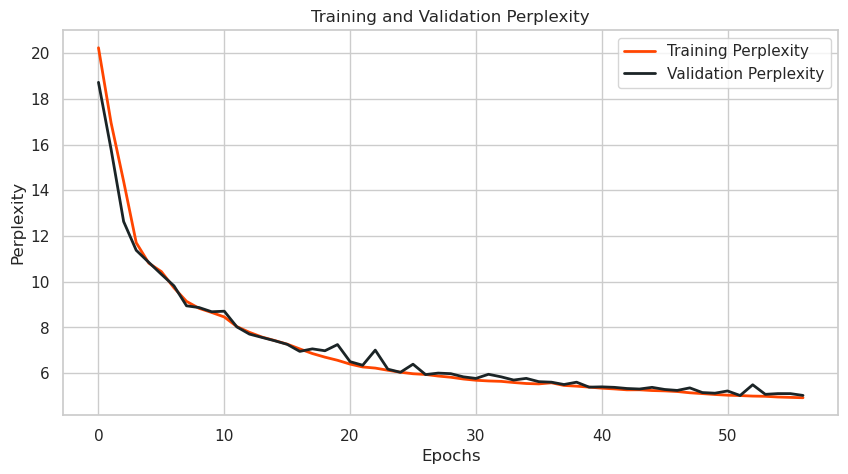

In [55]:
# perplexities
train_perplexities = [torch.exp(torch.tensor(loss)).item() for loss in train_losses]
val_perplexities = [torch.exp(torch.tensor(loss)).item() for loss in val_losses]

# plotting
sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
plt.plot(train_perplexities, label='Training Perplexity', linewidth=2, color='#ff4500')
plt.plot(val_perplexities, label='Validation Perplexity', linewidth=2, color='#1b2426')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity')
plt.legend()

# save
plt.savefig("../../website-source/img/ml-plots/training-validation-perplexity-plot-rnn.png")

# show
plt.show()



In [53]:
def generate_text(model, start_string, length, temperature=1):

    
    # put the model in evaluation mode
    model.eval()

    # convert start_string characters to indices
    input_eval = [char2idx.get(s, char2idx['UNK']) for s in start_string]
    input_eval = torch.tensor(input_eval, dtype=torch.long).unsqueeze(0).to(device)

    generated_text = []

    with torch.no_grad():
        for _ in range(length):
            output = model(input_eval)
            output = output[:, -1, :] / temperature
            probabilities = F.softmax(output, dim=-1)
            predicted_id = torch.multinomial(probabilities, num_samples=1)

            # append to the input for the next character prediction
            input_eval = torch.cat([input_eval, predicted_id], dim=1)

            generated_text.append(idx2char[predicted_id.item()])

    return start_string + ''.join(generated_text)




In [54]:
#  usage
prompt = "Once upon a time"
generated = generate_text(model, prompt, 100)  # Generates 100 characters
print(generated)



Once upon a time morchess hour. thhey going how march out. well was story the keept wasled ilreay.forse inquy begard
